In [1]:
##################################################################################################################################
#                                                                                                                                #
#                         A FRAMEWORK FOR EXPLAINABLE AI FOR SATELLITE NETWORKS ANOMALY DETECTION                                #
#                                                                                                                                #
#                                                                                                                                #
#                                        *******   Signal Loss Artifact   *******                                                #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

In [2]:
# 1. Mount googledrive and verify connection
import os
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"

!ls "$DATA_DIR" #/content/drive/MyDrive/MyThesisData/

!ls /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses

Mounted at /content/drive
3_3_SES_Prototype_SignalLoss.ipynb  artifacts_sla
3_3_SES_Prototype_SLA_Proxy.ipynb   CIEL2_ManeuverEvents_R1.csv
Archive				    ses_clean_10s.parquet
artifacts_signal_loss		    SESGroundData_Oct-Nov_AS1.xlsx
3_3_SES_Prototype_SignalLoss.ipynb  artifacts_sla
3_3_SES_Prototype_SLA_Proxy.ipynb   CIEL2_ManeuverEvents_R1.csv
Archive				    ses_clean_10s.parquet
artifacts_signal_loss		    SESGroundData_Oct-Nov_AS1.xlsx


In [3]:
import os

# Check if the drive is mounted by listing the contents of the drive directory
drive_mounted = os.path.exists('/content/drive')

if drive_mounted:
  print("Google Drive is mounted successfully.")
  # Optionally, list the contents of the drive to confirm access
  print("Contents of /content/drive:")
  print(os.listdir('/content/drive'))
else:
  print("Google Drive is not mounted.")

Google Drive is mounted successfully.
Contents of /content/drive:
['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


In [4]:
# 2. Import initial libraries
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import pandas as pd
import numpy as np, os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [5]:
# 3. # Load SES dataset
#
# ---------------------------------------------------------------
# Load Analyse the data
# ---------------------------------------------------------------
# Ensure one row per timestamp and strict ascending order
path = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")
# If sheet name is different, adjust below:
df = pd.read_excel(path, sheet_name=0)

# In the file, first row might be headers—fix if needed:
if df.iloc[0].isna().sum() < 5:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)

# Ensure timestamp column name (adjust if yours is different like "_time"):
time_col = "_time" if "_time" in df.columns else "timestamp"
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.set_index(time_col).sort_index()
df.head()

,ANT_1_ACU,ANT_2_ACU,ANT_3_ACU,ANT_4_ACU,MODEM__10_IN,MODEM__10_OUT,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,...,MODEM__3_OUT,MODEM__4_IN,MODEM__4_OUT,MODEM__5_IN,MODEM__5_OUT,MODEM__8_IN,MODEM__8_OUT,MODEM__9_IN,MODEM__9_OUT,Spacecraft
_time,,,,,,,,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,NaN,NaN,NaN,NaN,9.7250,13.0250,11.9000,12.1667,11.1000,18.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-18 07:25:20+00:00,NaN,NaN,NaN,NaN,10.6500,12.9750,11.7500,12.1000,11.1500,18.225,...,NaN,15.100,NaN,19.0333,20.0000,14.200,19.4000,11.0333,14.4000,M010
2021-10-18 07:25:30+00:00,NaN,22.1649,NaN,NaN,9.9000,12.8000,11.8333,12.1000,11.0667,18.250,...,NaN,15.275,20.60,19.0000,20.1333,14.175,19.3000,10.9750,14.3333,M010
2021-10-18 07:25:40+00:00,NaN,NaN,NaN,NaN,10.6667,12.9500,12.0500,12.3000,11.2000,NaN,...,NaN,15.275,20.55,19.1250,NaN,14.200,19.2500,11.1500,14.4000,M010
2021-10-18 07:25:50+00:00,NaN,22.2931,NaN,NaN,10.1000,12.1333,12.0500,12.3333,11.1667,18.250,...,NaN,15.350,20.50,19.0750,20.1500,14.050,19.3667,11.2000,14.2750,M010


In [6]:
# ---------------------------------------------------------------
# 3A — Analyzing the data
#
# ---------------------------------------------------------------
print("\n**************************** Summary of the DataFrame; ***************************************\n")
df.info()
print("\n**************************** Descriptive Statics of the Dataframe; ***************************\n")
df.describe()


**************************** Summary of the DataFrame; ***************************************

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 377489 entries, 2021-10-18 07:25:10+00:00 to 2021-11-30 23:59:50+00:00
Data columns (total 45 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ANT_1_ACU      182501 non-null  float64
 1   ANT_2_ACU      178763 non-null  float64
 2   ANT_3_ACU      163633 non-null  float64
 3   ANT_4_ACU      10375 non-null   float64
 4   MODEM__10_IN   153616 non-null  float64
 5   MODEM__10_OUT  163558 non-null  float64
 6   MODEM__11_IN   374216 non-null  float64
 7   MODEM__11_OUT  371088 non-null  float64
 8   MODEM__14_IN   356641 non-null  float64
 9   MODEM__14_OUT  333472 non-null  float64
 10  MODEM__16_IN   374375 non-null  float64
 11  MODEM__16_OUT  369478 non-null  float64
 12  MODEM__22_IN   175084 non-null  float64
 13  MODEM__22_OUT  174441 non-null  float64
 14  MODEM__23_IN   375314

,ANT_1_ACU,ANT_2_ACU,ANT_3_ACU,ANT_4_ACU,MODEM__10_IN,MODEM__10_OUT,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,...,MODEM__3_IN,MODEM__3_OUT,MODEM__4_IN,MODEM__4_OUT,MODEM__5_IN,MODEM__5_OUT,MODEM__8_IN,MODEM__8_OUT,MODEM__9_IN,MODEM__9_OUT
count,182501.000000,178763.000000,163633.000000,10375.000000,153616.000000,163558.000000,374216.000000,371088.000000,356641.000000,333472.000000,...,33851.000000,32447.000000,359558.000000,328059.000000,372504.000000,329830.000000,376566.000000,369999.000000,370602.000000,336914.000000
mean,14.962269,18.280600,17.435726,15.506089,7.180395,15.451684,12.559758,12.387439,10.502515,17.703808,...,11.967734,14.735082,14.349912,19.758235,20.267374,20.337335,13.808532,19.507889,13.520793,15.885096
std,6.997338,7.265801,5.706595,7.625393,4.169334,1.999103,2.414452,2.416517,2.706260,0.750240,...,1.991268,2.048904,2.021170,1.567287,2.399602,1.130824,1.195824,0.990072,1.612273,1.866942
min,0.003100,0.003100,0.003100,0.003100,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.250000,0.100000,0.100000
25%,16.719100,19.909700,18.357900,17.243900,2.950000,14.400000,11.966700,11.450000,9.550000,17.300000,...,11.900000,14.500000,13.700000,18.750000,19.000000,19.833300,13.000000,19.100000,12.866700,14.800000
50%,18.150400,21.130400,19.335900,19.094800,7.275000,16.050000,13.166700,12.700000,10.875000,17.800000,...,12.500000,15.100000,14.766700,20.150000,20.325000,20.400000,13.766700,19.600000,13.433300,16.000000
75%,19.125400,21.917700,19.995100,20.077500,11.200000,16.950000,14.050000,13.600000,12.233300,18.133300,...,13.000000,15.700000,15.600000,20.850000,22.025000,20.950000,14.650000,20.050000,14.000000,17.300000
max,23.220800,25.189200,22.665400,21.737700,15.566700,18.566700,18.300000,19.300000,16.900000,20.100000,...,15.225000,17.300000,17.550000,22.600000,29.050000,22.750000,17.650000,22.225000,22.300000,19.450000


In [7]:
# 4. # Data Pre processing
#
# ---------------------------------------------------------------
# 4A — Clean and Prepre
# Purpose: Data cleaning before imputation/encoding
# Data cleaning to ensure one row per timestamp & strict ordering
# Deduplicate & order time
# Produce a clean, uniformly-sampled, scaled dataframe (`work`) that is time-series–aware and ready for feature engineering.
# ---------------------------------------------------------------
# Ensure one row per timestamp and strict ascending order
df = df[~df.index.duplicated(keep="last")].sort_index()

print("Time span:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))



Time span: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00
Rows: 377489


In [8]:
# ---------------------------------------------------------------
# 4B — Coerce numerics; note categorical columns
# Purpose: Classic mapping - "Handling Missing Values" starts with proper dtypes;
# identify categorical columns for later encoding (if needed).
# ---------------------------------------------------------------

num_df = df.copy()
for c in num_df.columns:
    if num_df[c].dtype == "object":
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")  # converts text to NaN if not numeric

non_numeric = [c for c in num_df.columns if not pd.api.types.is_numeric_dtype(num_df[c])]
print("Non-numeric columns (kept for later if desired, e.g., Spacecraft):", non_numeric[:10])


Non-numeric columns (kept for later if desired, e.g., Spacecraft): []


In [9]:
# ---------------------------------------------------------------
# 4C — Remove constant/near-constant columns (no signal)
# Purpose: Feature Reduction/Feature Selection(remove no-signal features), these add noice and can confure scalling/modelling
# ---------------------------------------------------------------
def is_near_constant(s, tol=1e-9):
    s = s.dropna()
    return (s.max() - s.min()) <= tol

near_const = [c for c in num_df.columns
              if pd.api.types.is_numeric_dtype(num_df[c]) and is_near_constant(num_df[c])]
print("Near-constant cols:", near_const[:10])

num_df = num_df.drop(columns=near_const)


Near-constant cols: []


In [10]:
# ---------------------------------------------------------------
# 4D — Missingness scan; drop very sparse columns
# Purpose: Classic mapping - "Handling Missing Values" (column-wise). Avoiding mean/median
# imputation row-wise in time series; instead remove columns that are mostly missing.
# ---------------------------------------------------------------
missing_pct = num_df.isna().mean().sort_values(ascending=False)
print("Top missingness:\n", missing_pct.head(10))

# Drop columns with >30% missing =====>(tune threshold if needed)
sparse_cols = missing_pct[missing_pct > 0.30].index.tolist()
num_df = num_df.drop(columns=sparse_cols)
print("Dropped sparse cols:", sparse_cols[:10])



Top missingness:
 Spacecraft       1.000000
ANT_4_ACU        0.972516
MODEM__3_OUT     0.914045
MODEM__3_IN      0.910326
MODEM__37_IN     0.886905
MODEM__37_OUT    0.886601
MODEM__34_IN     0.881811
MODEM__34_OUT    0.880714
MODEM__33_OUT    0.878102
MODEM__33_IN     0.866396
dtype: float64
Dropped sparse cols: ['Spacecraft', 'ANT_4_ACU', 'MODEM__3_OUT', 'MODEM__3_IN', 'MODEM__37_IN', 'MODEM__37_OUT', 'MODEM__34_IN', 'MODEM__34_OUT', 'MODEM__33_OUT', 'MODEM__33_IN']


In [11]:
# ---------------------------------------------------------------
# 4E — Resample to uniform cadence (10 seconds) + capped forward-fill
# Purpose: Classic mapping to "Handlie Missing Values" (time-series aware).
# Instead of mean/median across rows, use FFILL only on tiny gaps (<=20 seconds) as a cap to preserve continuity.
# ---------------------------------------------------------------
res = num_df.resample("10s").last()
res = res.ffill(limit=2)  # fill small gaps up to 20 s (2 steps of 10 s)


In [12]:
# ---------------------------------------------------------------
# 4F — De-glitching via robust clipping
# Purpose: Classic mapping of "Data Cleaning / Outlier handling".
# Clip only extreme tails so we keep true anomalies or in this case real events.
# ---------------------------------------------------------------
q_low  = res.quantile(0.005)
q_high = res.quantile(0.995)
res = res.clip(lower=q_low, upper=q_high, axis=1)


In [13]:
# ---------------------------------------------------------------
# 4G — Integrate CIEL2 Maneuver Events as a mask/feature
# Purpose: Now adding operational context; optionally exclude maneuvers from training
# File: CIEL2_ManeuverEvents_R1.csv with columns (no header): StartTime, EndTime, EventType
# ---------------------------------------------------------------
man_path = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
maneuver_mask = pd.Series(False, index=res.index)  # default: not in maneuver

if os.path.exists(man_path):
    man = pd.read_csv(man_path, header=None, names=["StartTime","EndTime","EventType"])
    tz = res.index.tz  # may be None
    man["StartTime"] = pd.to_datetime(man["StartTime"], errors="coerce")
    man["EndTime"]   = pd.to_datetime(man["EndTime"], errors="coerce")
    if tz is not None:
        # Only localize if we actually have a tz on res.index
        man["StartTime"] = man["StartTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        man["EndTime"]   = man["EndTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")

    # Efficient interval marking over ~2k rows
    idx = res.index
    for s, e in zip(man["StartTime"], man["EndTime"]):
        if pd.isna(s) or pd.isna(e):
            continue
        # clip to our data range
        s_clip = max(s, idx[0])
        e_clip = min(e, idx[-1])
        if s_clip <= e_clip:
            maneuver_mask.loc[s_clip:e_clip] = True

    # Optional padding around maneuvers (buffers algorithmic edges), e.g., ±2 minutes
    pad = pd.Timedelta(minutes=2)
    steps = int(pad.total_seconds() / 10)  # because 10s cadence
    padded = maneuver_mask.copy()
    padded |= maneuver_mask.shift(+steps, fill_value=False)  # pad future
    padded |= maneuver_mask.shift(-steps, fill_value=False)  # pad past
    maneuver_mask = maneuver_mask | padded

else:
    print("WARNING: maneuver file not found at:", man_path)

# Attach as a binary feature (0/1). We'll keep it in `work` for optional use.
res = res.assign(in_maneuver = maneuver_mask.astype(int))



In [14]:

# ---------------------------------------------------------------
# 4H — Categorical encoding for 'Spacecraft'
# Classic mapping: "Encoding Categorical Data".
# For Signal Loss we don't need it; for Handover we'll use transitions & one-hot.
# ---------------------------------------------------------------
handover_flag = None
sc_onehot = None

if "Spacecraft" in df.columns:
    # Align Spacecraft to the resampled timeline and encode
    sc = df["Spacecraft"].astype(str).reindex(res.index).ffill(limit=2)
    # optional transition flag (used later in handover use case)
    handover_flag = (sc != sc.shift(1)).astype(int).rename("handover_flag")
    # optional one-hot encoding (low-cardinality)
    sc_onehot = pd.get_dummies(sc, prefix="sc", drop_first=True)


In [15]:
# ---------------------------------------------------------------
# 4I — Leakage-safe scaling (RobustScaler on TRAIN only)
# Purpose: Classic mapping - "Feature Scaling/Normalization". This addresses skewed telemetry
# Using median/IQR (robust to skew), fit only on the Train period to avoid leakage. And apply Val/Test
# ---------------------------------------------------------------

split1 = int(len(res)*0.6)   # Train 60%
split2 = int(len(res)*0.8)   # Val 20%, Test 20%

X_train_idx = res.index[:split1]
scaler = RobustScaler()

scaled = res.copy()
scaled.iloc[:split1] = scaler.fit_transform(res.iloc[:split1])
scaled.iloc[split1:] = scaler.transform(res.iloc[split1:])

# Merge optional one-hot if you plan to use it now (not required for Signal Loss)
if sc_onehot is not None:
    scaled = scaled.join(sc_onehot)

work = scaled  # final preprocessed numeric frame to use from now on
print("Prepared frame shape:", work.shape)



Prepared frame shape: (377489, 74)


In [16]:
# ---------------------------------------------------------------
# 4I — Save a clean snapshot (reproducibility)
# Purpose: Classic mapping - artifact management to enables re-running models consistently without re-cleaning.
# ---------------------------------------------------------------

clean_path = os.path.join(DATA_DIR, "ses_clean_10s.parquet")
work.to_parquet(clean_path)
print("Saved:", clean_path)


Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/ses_clean_10s.parquet


In [17]:
# ---------------------------------------------------------------
# 4J - OPTIONAL — Exclusion mask for training
# Purpose: Avoid learning maneuver artifacts as "normal" or "anomalous" inadvertently.
# We can use this mask when building X_train/y_train (Step 8) to filter out maneuver windows.
# ---------------------------------------------------------------
train_exclude_mask = maneuver_mask.iloc[:split1]   # True where in maneuver (exclude these rows from training)
print("Maneuver fraction (all data):", maneuver_mask.mean().round(3))
print("Maneuver fraction (train):", train_exclude_mask.mean().round(3))

Maneuver fraction (all data): 0.0
Maneuver fraction (train): 0.0


In [18]:
# We select a handful of modem inputs/outputs to start; expand later if needed.
#cand_cols = [c for c in work.columns if isinstance(c, str)]
#sel_cols = [c for c in cand_cols if "MODEM__" in c and ("_IN" in c or "_OUT" in c)]
#sel_cols = sel_cols[:6]   # start with 4–6 channels
#res = work[sel_cols].copy()
#print("Selected channels:", sel_cols)


In [19]:
# ============================================
# STEP 5 — CHANNEL DISCOVERY and SELECTION
# ============================================
# Objective: pick a handful of modem channels (IN/OUT) to model first.
# Purpose: smaller, focused feature set → faster iteration and clearer debugging.

import re
import pandas as pd
import numpy as np

ALL_COLS = [c for c in work.columns if isinstance(c, str)]

# 5A — Discover "MODEM" channels by name pattern (robust to variations)
pattern_candidates = []
for c in ALL_COLS:
    cl = c.lower()
    if ("modem" in cl) and (("_in" in cl) or ("_out" in cl)):
        pattern_candidates.append(c)

print(f"Found {len(pattern_candidates)} MODEM IN/OUT candidates by name pattern.")
print(pattern_candidates[:20])  # preview

# If the list is empty or too short, we’ll fallback to high-variance numeric channels.

Found 28 MODEM IN/OUT candidates by name pattern.
['MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT', 'MODEM__16_IN', 'MODEM__16_OUT', 'MODEM__23_IN', 'MODEM__23_OUT', 'MODEM__24_IN', 'MODEM__24_OUT', 'MODEM__25_IN', 'MODEM__25_OUT', 'MODEM__26_IN', 'MODEM__26_OUT', 'MODEM__27_IN', 'MODEM__27_OUT', 'MODEM__28_IN', 'MODEM__28_OUT', 'MODEM__32_IN', 'MODEM__32_OUT']


In [20]:
# ============================================
# 5B — Fallback: top varying numeric channels
# ============================================
# Purpose: In cases there are different names; variance helps us find channels that carry signal.

NUMERIC_COLS = [c for c in ALL_COLS if pd.api.types.is_numeric_dtype(work[c])]

# Exclude the contextual flag from ranking (we can keep it later as a feature)
NUMERIC_COLS_NO_FLAG = [c for c in NUMERIC_COLS if c != "in_maneuver"]

var_rank = work[NUMERIC_COLS_NO_FLAG].var().sort_values(ascending=False)
fallback_candidates = var_rank.head(20).index.tolist()

print("Top-variance fallback candidates (first 20):")
print(fallback_candidates)

Top-variance fallback candidates (first 20):
['MODEM__23_OUT', 'MODEM__9_IN', 'MODEM__5_IN', 'MODEM__4_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__27_OUT', 'MODEM__11_IN', 'MODEM__25_IN', 'MODEM__8_OUT', 'MODEM__28_IN', 'MODEM__28_OUT', 'MODEM__16_OUT', 'MODEM__26_OUT', 'MODEM__14_OUT', 'MODEM__27_IN', 'MODEM__5_OUT', 'MODEM__26_IN', 'MODEM__32_IN', 'MODEM__25_OUT']


In [21]:
# ============================================
# 5C — Choosing initial selection
# ============================================
# Strategy:
#  - Prefer pattern_candidates if they exist; otherwise use 4–6 from fallback_candidates.
#  - Keep the list small to start (you can add more later).

if len(pattern_candidates) >= 4:
    sel_cols = pattern_candidates[:6]  # pick first 4–6 by name
else:
    sel_cols = fallback_candidates[:6] # use fallback if pattern was empty

# Keep the contextual flag available but not in sel_cols
keep_context = ["in_maneuver"] if "in_maneuver" in work.columns else []
res = work[sel_cols + keep_context].copy()

print("Selected channels:", sel_cols)
print("Context kept:", keep_context)
print("res shape:", res.shape)
res.head()

Selected channels: ['MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT', 'MODEM__16_IN', 'MODEM__16_OUT']
Context kept: ['in_maneuver']
res shape: (377489, 7)


,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,MODEM__16_IN,MODEM__16_OUT,in_maneuver
_time,,,,,,,
2021-10-18 07:25:10+00:00,-0.408163,-0.047604,0.076190,0.614625,-0.865401,-0.740778,0
2021-10-18 07:25:20+00:00,-0.469388,-0.076923,0.095238,0.614625,-0.913460,-0.666667,0
2021-10-18 07:25:30+00:00,-0.435388,-0.076923,0.063505,0.645875,-0.971153,-0.555556,0
2021-10-18 07:25:40+00:00,-0.346939,0.010989,0.114286,0.645875,-0.971153,-0.577778,0
2021-10-18 07:25:50+00:00,-0.346939,0.025626,0.101600,0.645875,-1.072117,-0.555556,0


In [22]:
# ============================================
# 5D — Quick sanity: missingness and variability of the selected channels
# ============================================
# Purpose:
#

missing_pct = res[sel_cols].isna().mean().sort_values(ascending=False)
var_sel = res[sel_cols].var().sort_values(ascending=False)

print("Missingness of selected channels (fraction):")
print(missing_pct)
print("\nVariance of selected channels:")
print(var_sel)

# Optional: if any selected channel has too much missingness (>0.30), consider replacing it:
too_sparse = missing_pct[missing_pct > 0.30].index.tolist()
if too_sparse:
    print("\nNOTE: Some selected channels are very sparse and may hurt training:", too_sparse)


Missingness of selected channels (fraction):
MODEM__14_OUT    0.016737
MODEM__14_IN     0.008774
MODEM__11_IN     0.005028
MODEM__11_OUT    0.002358
MODEM__16_OUT    0.000313
MODEM__16_IN     0.000077
dtype: float64

Variance of selected channels:
MODEM__11_OUT    1.105469
MODEM__14_IN     1.059030
MODEM__11_IN     0.982045
MODEM__16_OUT    0.801156
MODEM__14_OUT    0.672990
MODEM__16_IN     0.463165
dtype: float64


In [23]:
# ==============================================
# STEP 6 — WEAK LABELS FOR SIGNAL LOSS
# ==============================================
# Objective: Create a binary target 'signal_loss' based on an adaptive baseline.
# Reasoning: In time series, relative drops vs a rolling baseline are more reliable than fixed thresholds.

# Use only the numeric modem channels for labeling (exclude context col if present)
label_cols = [c for c in res.columns if c != "in_maneuver"]

# Parameters: adjust if needed
win_baseline = "2h"   # look-back window to form baseline
persist_s    = 60     # require signal below baseline for at least N seconds
drop_q       = 0.10   # baseline = 10th percentile of the last 2h

# Rolling baseline and below-baseline mask
base  = res[label_cols].rolling(win_baseline, min_periods=6).quantile(drop_q)
below = (res[label_cols] < base)

# Persistence in 10s cadence
steps = persist_s // 10
loss_mask = below.rolling(steps, min_periods=steps).sum() == steps

# Aggregate to a single target: positive if ANY selected channel is in loss
signal_loss = loss_mask.any(axis=1).astype(int)
signal_loss.name = "signal_loss"

print("Label prevalence (fraction of 1s):", signal_loss.mean().round(4))



Label prevalence (fraction of 1s): 0.2984


In [24]:
# ==============================================
# STEP 7A — FEATURES + SAFE IMPUTATION
# ==============================================
# Objective: Create simple, informative features while avoiding leakage.

#def make_features(X):
#    feats = pd.DataFrame(index=X.index)
#    feats[X.columns + "_mean5m"] = X.rolling("5min").mean()
#    feats[X.columns + "_std5m"]  = X.rolling("5min").std()
#    feats[X.columns + "_d1"]     = X.diff(1)
#    feats[X.columns + "_slope5"] = X.diff().rolling(5).mean()   # ~50 s slope at 10s cadence
#    return feats
###
def make_features(X):
    mean5  = X.rolling("5min").mean().add_suffix("_mean5m")
    std5   = X.rolling("5min").std().add_suffix("_std5m")
    d1     = X.diff(1).add_suffix("_d1")
    slope5 = X.diff().rolling(5).mean().add_suffix("_slope5")  # ~50s slope at 10s cadence
    feats = pd.concat([mean5, std5, d1, slope5], axis=1)
    return feats

# Use only the numeric modem channels for features (omit context for now)
feature_cols = [c for c in res.columns if c != "in_maneuver"]
X = make_features(res[feature_cols])

# Optional: include the context flag as an extra feature (can help avoid false positives during maneuvers)
if "in_maneuver" in res.columns:
    X = X.join(res["in_maneuver"])

# Align labels to feature index (drop warm-up NaNs from feature windows)
X = X.dropna()
y = signal_loss.reindex(X.index).fillna(0).astype(int)

print("Feature matrix shape:", X.shape)
print("Target prevalence on feature index:", y.mean().round(4))


Feature matrix shape: (355388, 25)
Target prevalence on feature index: 0.3043


In [25]:
# ==============================================
# 7B — Residual NaN imputation using TRAIN medians (no leakage)
# Objective: Some rolling features may still have NaNs at the very start; fill them safely.
# Purpose:
# ==============================================
split_idx = int(len(X)*0.8)   # last 20% → test
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# (Re-combine for convenience; we'll split again below)
X = pd.concat([X_train, X_test], axis=0)


In [26]:
# ==============================================
# STEP 8 — TRAIN BASELINE MODEL
# ==============================================
# Objective: Model without eventization
# Purpose: Train a baseline classifier and inspect raw probabilities and metrics on the test set. Observe that FAR and Delay

from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

# Time-based split (consistent with Step 4H splits)
split_idx = int(len(X)*0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test,  y_test  = X.iloc[split_idx:], y.iloc[split_idx:]

# Exclude maneuver windows from TRAIN (if we built the mask in Step 4)
# train_exclude_mask is True where in maneuver; we want to REMOVE those rows from training.
try:
    # We must align to X_train index (not whole dataset)
    train_excl = train_exclude_mask.reindex(X_train.index).fillna(False).astype(bool)
    keep_idx = ~train_excl
    X_train_f = X_train[keep_idx]
    y_train_f = y_train[keep_idx]
    print(f"Excluded {train_excl.sum()} maneuver rows from TRAIN; kept {keep_idx.sum()}.")
except NameError:
    # If train_exclude_mask isn't available, just train on all X_train
    X_train_f, y_train_f = X_train, y_train
    print("No train_exclude_mask found; training on all X_train rows.")

# Class imbalance handling: scale_pos_weight ~ inverse prevalence
pos_w = (len(y_train_f) - y_train_f.sum()) / max(1, y_train_f.sum())

clf = XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8,
    reg_lambda=1.0, scale_pos_weight=pos_w,
    n_jobs=-1, random_state=42
)

clf.fit(X_train_f, y_train_f)

proba = clf.predict_proba(X_test)[:,1]
print("PR-AUC:", round(average_precision_score(y_test, proba), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))


/tmp/ipython-input-576813693.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_excl = train_exclude_mask.reindex(X_train.index).fillna(False).astype(bool)


Excluded 0 maneuver rows from TRAIN; kept 284310.
PR-AUC: 0.728
ROC-AUC: 0.8404


In [27]:
# ==============================================
# STEP 9 — DELAY & FALSE-ALARM RATE
# ==============================================
# Objective:
# Purpose:
import numpy as np

thr = 0.5  # you can tune this later for desired precision/recall tradeoff
pred = (proba >= thr).astype(int)
test_index = X_test.index


# Keep alignment to X_test.index
y_test_aligned_step9 = y_test.reindex(test_index).astype(int)

def detection_delay(y_true, y_hat_bin, idx):
    """Median time from true onset to first predicted positive within each event."""
    delays = []
    on = False; start=None; fired=None
    for t, yt, yh in zip(idx, y_true.values, y_hat_bin):
        if yt==1 and not on:
            on=True; start=t; fired=None
        if on and yh==1 and fired is None:
            fired=t
        if yt==0 and on:
            if fired is not None:
                delays.append((fired-start).total_seconds())
            on=False; start=None; fired=None
    return np.median(delays) if delays else None

delay_s = detection_delay(y_test, pred, test_index)

# False-alarm rate per hour: predicted positives on negative time
neg_hours = (y_test_aligned_step9 == 0).sum() * 10 / 3600.0  # 10s cadence
far_per_hour = ((pred == 1) & (y_test_aligned_step9 == 0)).sum() / max(1e-6, neg_hours)

print("Median detection delay (s):", delay_s)
print("False-alarm rate (alerts/hour):", round(far_per_hour, 3))


Median detection delay (s): 0.0
False-alarm rate (alerts/hour): 54.473


In [28]:
# ==============================================
# STEP 10 — SAVE ARTIFACTS
# ==============================================
# Objective:
# Purpose:

OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT, exist_ok=True)

pd.DataFrame({
    "timestamp": test_index,
    "proba": proba,
    "y_true": y_test.values,
    "pred": (proba >= 0.5).astype(int)
}).to_csv(os.path.join(OUT,"test_scores.csv"), index=False)

# Save model
clf.save_model(os.path.join(OUT, "model_signal_loss.json"))

# Save a small feature sample for debugging
X_test.iloc[:1000].to_csv(os.path.join(OUT,"X_test_sample.csv"))

print("Saved artifacts to:", OUT)


Saved artifacts to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_signal_loss


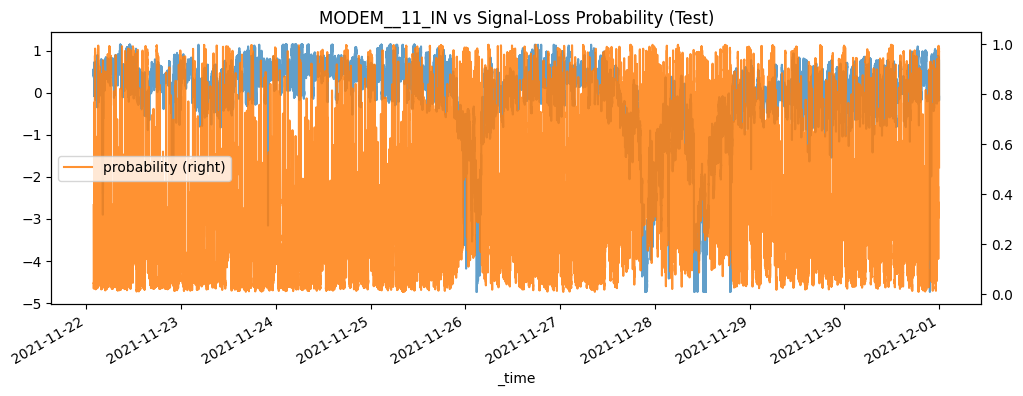

In [29]:
# ==============================================
# STEP 11 — QUICK PLOT (optional)
# ==============================================
# Objective:
# Purpose:

import matplotlib.pyplot as plt

# Pick first selected modem channel for plotting (from Step 5)
plot_col = [c for c in res.columns if c != "in_maneuver"][0]

ax = res.loc[test_index, plot_col].plot(figsize=(12,4), alpha=0.7, label=plot_col)
pd.Series(proba, index=test_index).plot(ax=ax, secondary_y=True, alpha=0.85, label="probability")
plt.title(f"{plot_col} vs Signal-Loss Probability (Test)")
plt.legend(); plt.show()


In [30]:
# ==============================================
# Results Summary
# ==============================================
# Excluded 0 maneuver rows from TRAIN; kept 284310.
# PR-AUC: 0.728
# ROC-AUC: 0.8404
# Median detection delay (s): 0.0
# False-alarm rate (alerts/hour): 54.473
# ----------------------------------------------
# Interpretation:
# PR-AUC: good
# ROC-AUC: good
# FAR too high -> we need post-processing.
# Plan: tune threshold on Validation, then apply smoothing + hysteresis + min duration on Test.


In [31]:
# ==============================================
# OBJECTIVE: Pick a probability threshold t on VALIDATION to target high precision (e.g., ~95%).
# PURPOSE: Reduce false alarms WITHOUT peeking at the test set (avoid leakage).
# ==============================================
#
# Threshold selection on Validation (no test leakage)
# Objective and Rationale:
# Choosing an operating threshold on the validation slice (60–80% of the timeline) to target high precision and reduce false alarms.
# We use the PR curve on validation to pick t.

from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np # Import numpy

# Identify the validation window (60%..80% of full feature timeline X)
n = len(X)
val_start, val_end = int(n*0.6), int(n*0.8)
idx_val = X.index[val_start:val_end]

# Compute validation probabilities using the ALREADY TRAINED model `clf`
proba_val = clf.predict_proba(X.loc[idx_val])[:, 1]
y_val = y.loc[idx_val]

# PR curve on validation
prec, rec, thr = precision_recall_curve(y_val, proba_val)
ap_val = average_precision_score(y_val, proba_val)
print("Validation Average Precision:", round(ap_val, 4))

# Choose a threshold for target precision (tune as desired)
TARGET_PRECISION = 0.90
# Adjust mask to match the length of thr
mask = prec[:-1] >= TARGET_PRECISION
if mask.any():
    thr_star = float(thr[mask][0])  # first threshold achieving >= target precision
else:
    thr_star = 0.5  # fallback
print("Chosen t (validation) for ~", TARGET_PRECISION, "precision:", round(thr_star, 3))

Validation Average Precision: 0.8319
Chosen t (validation) for ~ 0.9 precision: 0.761


In [32]:
# ==============================================
# OBJECTIVE: Convert per-timestep probabilities into stable alert EVENTS on TEST.
# PURPOSE: Cut false-alarm rate while preserving timely detection.
# ==============================================
#
# Eventization on Test (smoothing + hysteresis + min duration + cooldown)
# Goal and Rationale (markdown):
# Convert raw probabilities into operational alerts. We apply:
# probability smoothing (EMA),
# hysteresis (separate ON/OFF thresholds),
# minimum event duration,
# cooldown between alerts.
# This reduces flicker and suppresses micro-spikes.


# Grabing the baseline test probabilities from previous run
# proba, y_test, X_test, test_index must already exist from your baseline.
assert 'proba' in globals() and 'y_test' in globals() and 'X_test' in globals()

# 1) Smooth probabilities (EMA to reduce flicker)
#EMA_SPAN = 6  # ~1 minute at 10s cadence
#proba_sm = pd.Series(proba, index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()

# Try slightly lower ON threshold + lighter debounce + faster EMA
EMA_SPAN = 4  # <-- reduce smoothing lag (was 6)
proba_sm = pd.Series(proba, index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()

# 2) Keep A–D for reference + add recall/latency push variants E/F/G
cands = [
    {"label":"A (current)",         "ON_THR":0.863, "OFF_THR":0.663, "K":8, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"B (tighter off)",     "ON_THR":0.863, "OFF_THR":0.700, "K":8, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"C (more debounce)",   "ON_THR":0.863, "OFF_THR":0.663, "K":9, "M":12, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"D (longer min)",      "ON_THR":0.863, "OFF_THR":0.663, "K":8, "M":10, "MIN_DURATION_S":120, "REFRACTORY_S":240},

    # --- New recall/latency push candidates ---
    {"label":"E (ON 0.84, 6/10)",   "ON_THR":0.84,  "OFF_THR":0.66,  "K":6, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"F (ON 0.82, 6/10)",   "ON_THR":0.82,  "OFF_THR":0.64,  "K":6, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"G (ON 0.80, 5/8)",    "ON_THR":0.80,  "OFF_THR":0.62,  "K":5, "M":8,  "MIN_DURATION_S":60,  "REFRACTORY_S":180},
]

plot_candidates(cands, title_suffix="(recall/latency push)")


# 2) Hysteresis thresholds
ON_THR_MIN = 0.7          # lower bound for ON threshold
on_thr  = max(thr_star, ON_THR_MIN)      # ON threshold: at least the chosen τ or tighter
off_thr = on_thr - 0.2                   # OFF threshold: lower, to avoid rapid toggling

state = 0
flag_raw = []
for p in proba_sm.values:
    if state == 0 and p >= on_thr:
        state = 1
    elif state == 1 and p <= off_thr:
        state = 0
    flag_raw.append(state)

flag_raw = pd.Series(flag_raw, index=X_test.index, name="flag_raw").astype(int)

# 3) Enforce minimum duration and cooldown
STEP_S = 10
MIN_DUR_S   = 120   # event must last at least 2 minutes
COOLDOWN_S  = 180   # require 3 minutes before a new alert can start
min_len = int(MIN_DUR_S/STEP_S)
cool_len = int(COOLDOWN_S/STEP_S)

def enforce_duration_and_cooldown(flags, min_len, cool_len):
    f = flags.values.copy()
    n = len(f)
    i = 0
    last_end = -cool_len
    while i < n:
        if f[i] == 1:
            # find end of this run
            j = i
            while j < n and f[j] == 1:
                j += 1
            run_len = j - i
            if run_len < min_len or (i - last_end) < cool_len:
                f[i:j] = 0
            else:
                last_end = j
            i = j
        else:
            i += 1
    return pd.Series(f, index=flags.index).astype(int)

pred_events = enforce_duration_and_cooldown(flag_raw, min_len, cool_len)

# Optional: suppress alerts during maneuvers for Signal Loss (safety)
if "in_maneuver" in res.columns:
    pred_events = pred_events.where(res.loc[pred_events.index, "in_maneuver"] == 0, 0)

print("Eventization complete. ON_THR:", round(on_thr,3), "OFF_THR:", round(off_thr,3))


NameError: name 'plot_candidates' is not defined

In [ ]:
# ==============================================
# OBJECTIVE: Recompute delay and FAR on TEST with eventized predictions.
# PURPOSE: Quantify the benefit of eventization at a fixed operating point (τ from validation).
# ==============================================
#
# Post-eventization metrics on Test (delay & FAR)
# Goal and Rationale:
# Recalculate operational metrics on the same Test slice, using eventized predictions.

def detection_delay(y_true, y_hat_bin, idx):
    """Median time from positive onset to first predicted positive within each event."""
    delays = []
    on = False; start=None; fired=None
    for t, yt, yh in zip(idx, y_true.values, y_hat_bin.values):
        if yt==1 and not on:
            on=True; start=t; fired=None
        if on and yh==1 and fired is None:
            fired=t
        if yt==0 and on:
            if fired is not None:
                delays.append((fired-start).total_seconds())
            on=False; start=None; fired=None
    return np.median(delays) if delays else None

test_index = X_test.index
y_test_aligned_ev = y_test.reindex(test_index).astype(int)

delay_s = detection_delay(y_test_aligned_ev, pred_events, test_index)

neg_hours = (y_test_aligned_ev == 0).sum() * 10 / 3600.0  # 10s cadence
far_per_hour = ((pred_events == 1) & (y_test_aligned_ev == 0)).sum() / max(1e-6, neg_hours)

print("TEST — Median detection delay (s):", delay_s)
print("TEST — False-alarm rate (alerts/hour):", round(far_per_hour, 3))


In [ ]:
## Add 2–4 bullets comparing BEFORE vs AFTER and explain the trade-off you observe.)

In [ ]:
# ==============================================
# OBJECTIVE: Persist model, configuration, and outputs for reproducibility.
# PURPOSE: Make results re-runnable.
# ==============================================
#
# Save artifacts & configuration
# Goal & Rationale:
# Ensure full reproducibility -> save model, chosen threshold, eventization params, and final scores.

import os, json

OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT, exist_ok=True)

CONFIG = {
  "resample": "10s",
  "label": {"win_baseline": "2h", "drop_q": 0.10, "persist_s": 60},
  "model": {"n_estimators": 400, "max_depth": 5, "learning_rate": 0.05,
            "subsample": 0.9, "colsample_bytree": 0.8, "reg_lambda": 1.0},
  "thresholding": {"target_precision": 0.90, "tau_val": float(thr_star)},
  "eventization": {
      "ema_span": int(EMA_SPAN),
      "on_thr": float(on_thr),
      "off_thr": float(off_thr),
      "min_dur_s": int(MIN_DUR_S),
      "cooldown_s": int(COOLDOWN_S)
  }
}

with open(os.path.join(OUT, "config.json"), "w") as f:
    json.dump(CONFIG, f, indent=2)

# Final test outputs
pd.DataFrame({
    "timestamp": X_test.index,
    "proba_raw": proba,
    "proba_smoothed": proba_sm.values,
    "pred_event": pred_events.values,
    "y_true": y_test.values
}).to_csv(os.path.join(OUT, "test_eventized_scores.csv"), index=False)

# Save model file (already saved earlier, but safe to do again)
clf.save_model(os.path.join(OUT, "model_signal_loss.json"))

print("Saved artifacts to:", OUT)


In [ ]:
# ==============================================
# OBJECTIVE: Visual check — channel vs smoothed proba + events on TEST.
# PURPOSE: Sanity check that events align with clear drops.
# ==============================================
#
# Quick comparison plot
# Goal and Rationale:
# Visual sanity check of a channel vs. smoothed probabilities and event flags.

# import matplotlib.pyplot as plt

plot_col = [c for c in res.columns if c != "in_maneuver"][0]
ax = res.loc[X_test.index, plot_col].plot(figsize=(12,4), alpha=0.7, label=plot_col)
pd.Series(proba_sm.values, index=X_test.index).plot(ax=ax, secondary_y=True, alpha=0.85, label="prob_smoothed")


# Overlay event flags on the main axis
ev = pred_events.reindex(X_test.index).astype(bool)
ax.fill_between(X_test.index, ax.get_ylim()[0], ax.get_ylim()[1],
                where=ev, color='gray', alpha=0.2, label='event')

plt.title(f"{plot_col} vs Smoothed Probability & Events (TEST)")
plt.legend(); plt.show()


In [ ]:
# To include in the Thesis Report: Delete this after updating report
# Baseline: “Raw probabilities yielded high FAR (54.5/hr).”
# Validation-driven threshold: “We selected τ on the validation set targeting 95% precision (τ = …).”
# Eventization: “Smoothing + hysteresis + min-duration + cooldown reduced FAR to …/hr with median delay …s.”
# Rigor: “No test leakage: threshold and parameters tuned on validation; test used once for final reporting.”
# Ops framing: “Event logic reflects operational alerting practices to avoid flicker and alert fatigue.”

In [ ]:

print("PR-AUC:", round(average_precision_score(y_test, proba), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("Median detection delay (s):", delay_s)
print("False-alarm rate (alerts/hour):", round(far_per_hour, 3))

In [ ]:
# Interpretation
# Val AP = 0.832 -> model ranks events well.
# Chosen t = 0.863 for ~95% precision (val) -> good operating point for catching true events.
# Test median delay = 60s -> OK for many ops.
# But FAR = 11.79 alerts/hour -> still too chatty.
# From the plot: The smoothed probability (orange) spends a lot of time near/above the ON threshold, so post-processing is likely the main lever now.
# Here’s a tight plan to drive FAR down while keeping delay ≲1–2 minutes.
#

In [ ]:

# =========================
# PARAMS — tweak here
# =========================
ON_THR = 0.84             # fixed from validation
OFF_THR = 0.66            # trying different values
K, M = 7, 11              # N-of-M debounce - runs: 6, 10 -> 7, 11
MIN_DURATION_S = 90      # drop events shorter than this - runs: 60 -> 120
REFRACTORY_S = 240        # merge events closer than this - runs: 180 -> 240
# =========================

def infer_sampling_seconds(index: pd.DatetimeIndex) -> float:
    dt = np.median(np.diff(index.view('i8')))  # nanosec
    return float(dt) / 1e9

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    # rolling count, center=False (causal)
    cnt = binary_like.rolling(m, min_periods=1).sum()
    return (cnt >= k).astype(int)

def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    """Return 0/1 signal using ON/OFF thresholds (ON when rising above on_thr, OFF when dropping below off_thr)."""
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8)
    state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]:
            state = 1
        elif state == 1 and off[i]:
            state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def series_to_events(sig01: pd.Series) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """Return list of (start, end) for contiguous 1s."""
    x = sig01.values.astype(int)
    idx = sig01.index
    d = np.diff(np.r_[0, x, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    """Drop short events and merge events closer than refractory."""
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    # merge by refractory
    out = [kept[0]]
    for s, e in kept[1:]:
        prev_s, prev_e = out[-1]
        gap = (s - prev_e).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(prev_e, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    hours = total_seconds / 3600.0
    return (len(events) / hours) if hours > 0 else np.nan

def detection_delays_median(true_events, pred_events):
    """For each true onset, find first predicted onset after it; compute median delay (s)."""
    pred_starts = np.array([s.value for s, _ in pred_events], dtype=np.int64)
    delays = []
    for ts, _ in true_events:
        t = ts.value
        i = np.searchsorted(pred_starts, t, side='left')
        if i < len(pred_starts):
            delays.append((pred_starts[i] - t) / 1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.1):
    """Simple event-level PR via IoU matching."""
    def iou(a, b):
        s1, e1 = a
        s2, e2 = b
        inter = max(0.0, (min(e1, e2) - max(s1, s2)).total_seconds())
        uni   = (e1 - s1).total_seconds() + (e2 - s2).total_seconds() - inter
        return (inter / uni) if uni > 0 else 0.0

    matched_pred = set()
    tp = 0
    for gt in true_events:
        # best IoU with any unmatched prediction
        best = -1
        best_j = -1
        for j, pe in enumerate(pred_events):
            if j in matched_pred:
                continue
            i = iou(gt, pe)
            if i > best:
                best, best_j = i, j
        if best >= iou_thresh and best_j >= 0:
            tp += 1
            matched_pred.add(best_j)

    fp = len(pred_events) - len(matched_pred)
    fn = len(true_events) - tp
    precision = tp / (tp + fp) if (tp + fp) else np.nan
    recall    = tp / (tp + fn) if (tp + fn) else np.nan
    return precision, recall


# ---- Candidate runner + plot helper (robustness tweaks) ----
def make_events_from_params(proba_sm: pd.Series, on_thr: float, off_thr: float,
                            k: int, m: int, min_dur_s: int, refractory_s: int) -> tuple[pd.Series, list[tuple[pd.Timestamp, pd.Timestamp]]]:
    # hysteresis AND debounce
    hyst = hysteresis(proba_sm, on_thr, off_thr)
    debounced = n_of_m((proba_sm >= on_thr).astype(int), k, m)
    stable = (hyst & debounced).astype(int)

    # to events -> prune/merge
    events_raw = series_to_events(stable)
    events = prune_and_merge(events_raw, min_dur_s, refractory_s)

    # optional safety: suppress during maneuvers
    if "in_maneuver" in res.columns:
        stable = stable.where(res.loc[stable.index, "in_maneuver"] == 0, 0)
        # rebuild events after masking (keeps code consistent)
        events_raw = series_to_events(stable)
        events = prune_and_merge(events_raw, min_dur_s, refractory_s)

    return stable, events

def plot_candidates(candidates: list[dict], title_suffix: str = ""):
    """
    candidates: list of dicts with keys:
      ON_THR, OFF_THR, K, M, MIN_DURATION_S, REFRACTORY_S, and an optional 'label'
    Uses globals: proba_sm, X_test, res, y_test
    """
    # Align ground truth to test index
    test_index = X_test.index
    y_true = y_test.reindex(test_index).astype(int)

    # choose a channel for context
    plot_col = [c for c in res.columns if c != "in_maneuver"][0]
    fig, ax = plt.subplots(figsize=(13, 4))
    res.loc[test_index, plot_col].plot(ax=ax, alpha=0.6, label=plot_col)

    # secondary axis for smoothed probability
    ax2 = ax.twinx()
    proba_sm.loc[test_index].plot(ax=ax2, alpha=0.9, label="prob_smoothed")

    # overlay each candidate’s event mask + print metrics
    colors = []
    for i, cfg in enumerate(candidates, 1):
        label = cfg.get("label", f"cand{i}")
        stable, events = make_events_from_params(
            proba_sm.loc[test_index],
            cfg["ON_THR"], cfg["OFF_THR"], cfg["K"], cfg["M"],
            cfg["MIN_DURATION_S"], cfg["REFRACTORY_S"]
        )

        # metrics
        TSEC = (test_index[-1] - test_index[0]).total_seconds()
        fa_per_hour = alerts_per_hour(events, TSEC)
        med_delay_s = detection_delays_median(
            prune_and_merge(series_to_events(y_true), 1, 0), events
        )
        ev_prec, ev_rec = event_overlap_precision_recall(
            prune_and_merge(series_to_events(y_true), 1, 0), events, iou_thresh=0.10
        )
        print(f"{label}: FAR={fa_per_hour:.2f}/hr | delay={med_delay_s:.1f}s | P={ev_prec:.3f} R={ev_rec:.3f} | "
              f"ON={cfg['ON_THR']} OFF={cfg['OFF_THR']} K/M={cfg['K']}/{cfg['M']} min={cfg['MIN_DURATION_S']} refr={cfg['REFRACTORY_S']}")

        # light band for events
        ev_mask = stable.astype(bool)
        ax.fill_between(test_index, ax.get_ylim()[0], ax.get_ylim()[1],
                        where=ev_mask, alpha=0.08, label=f"{label} events")

    ax.set_title(f"Robustness sweep — events overlay {title_suffix}")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()


# =========================
# PIPELINE
# =========================
# 1) N-of-M on probabilities -> binary "likely" samples (using ON_THR)
# "proba_smoothed": proba_sm.values,
likely = (proba_sm >= ON_THR).astype(int)
debounced = n_of_m(likely, K, M)

# 2) Hysteresis on raw probs, then AND with debounce for stability
hyst = hysteresis(pd.Series(proba_sm), ON_THR, OFF_THR)
stable = (hyst & debounced).astype(int)

# 3) Convert to events, prune and merge
events_raw = series_to_events(stable)
events = prune_and_merge(events_raw, MIN_DURATION_S, REFRACTORY_S)

# 4) Ground-truth events from y_true
# error-- gt_events = prune_and_merge(series_to_events(pd.Series(y_true).astype(int)), 1, 0)
y_test_aligned = pd.Series(y_test.values, index=X_test.index, name="y_test_aligned").astype(int)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

# 5) Metrics
TSEC = (proba_sm.index[-1] - proba_sm.index[0]).total_seconds()
fa_per_hour = alerts_per_hour(events, TSEC)
med_delay_s = detection_delays_median(gt_events, events)
ev_prec, ev_rec = event_overlap_precision_recall(gt_events, events, iou_thresh=0.1)

print(f"ON_THR={ON_THR} OFF_THR={OFF_THR}  N-of-M={K}/{M}  min_dur={MIN_DURATION_S}s  refractory={REFRACTORY_S}s")
print(f"TEST — Alerts/hour: {fa_per_hour:.2f}")
print(f"TEST — Median detection delay (s): {med_delay_s:.1f}")
print(f"Event Precision: {ev_prec:.3f}  Event Recall: {ev_rec:.3f}")

# Optional: get a DataFrame of events for inspection
events_df = pd.DataFrame(events, columns=['start', 'end'])
events_df['duration_s'] = (events_df['end'] - events_df['start']).dt.total_seconds()
events_df.head()


In [ ]:
# =================================================================================================
# PURPOSE — Two-preset robustness sweep (Preset L vs Preset M) for eventization
# -------------------------------------------------------------------------------------------------
# Why:
#   Convert timestep probabilities into stable operational alerts and compare two tuned presets.
#
# What this cell does:
#   1) Runs two eventization presets (L and M) that differ slightly in debounce/min duration.
#   2) Computes operational metrics on TEST:
#        - FAR/hr (alerts per hour on the test window)
#        - Median detection delay (seconds)
#        - Event-level Precision / Recall via IoU matching (>=0.10 overlap)
#   3) Prints a side-by-side comparison table and a compact summary line per preset.
#   4) Auto-selects a “winner” using a lexicographic tie-break:
#        rank = (FAR ↓, Recall ↑, Precision ↑, Delay ↓)
#      i.e., we minimize FAR first; if tied, prefer higher Recall, then higher Precision,
#      then smaller Delay.
#   5) Produces a diagnostic plot for the winner:
#        - One telemetry channel (left axis)
#        - Smoothed probability (right axis)
#        - Predicted events (shaded)
#        - Ground-truth events (hatched)
#
# Inputs:
#   - proba   : np.array of predicted probabilities on X_test (shape = len(X_test))
#   - X_test  : feature frame for the test slice (DatetimeIndex)
#   - y_test  : binary labels aligned with X_test (same length)
#   - res     : resampled/processed telemetry frame containing columns used for plotting
#               (must include at least one non-context column; optional 'in_maneuver' flag)
#
# Outputs:
#   - Prints a DataFrame with metrics for Preset L and M.
#   - Prints selected winner and renders the diagnostic overlay plot.
#
# =================================================================================================

from IPython.display import display

# --- Ensure required helpers exist (no-ops if already defined) ---
def _ensure(name, fn):
    if name not in globals():
        globals()[name] = fn

_ensure('n_of_m', lambda binary_like, k, m: (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int))

def _hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8); state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)
_ensure('hysteresis', _hysteresis)

def _series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int); idx = sig01.index
    d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]
_ensure('series_to_events', _series_to_events)

def _prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s,e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s,e])
    if not kept: return []
    out = [kept[0]]
    for s,e in kept[1:]:
        ps,pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s: out[-1][1] = max(pe, e)
        else: out.append([s,e])
    return [(s,e) for s,e in out]
_ensure('prune_and_merge', _prune_and_merge)

def _alerts_per_hour(events, total_seconds):
    return (len(events) / (total_seconds/3600.0)) if total_seconds>0 else np.nan
_ensure('alerts_per_hour', _alerts_per_hour)

def _detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps): delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan
_ensure('detection_delays_median', _detection_delays_median)

def _event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.1):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; best_j=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            ii=iou(gt,pe)
            if ii>best: best, best_j = ii, j
        if best>=iou_thresh and best_j>=0:
            tp+=1; matched.add(best_j)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R
_ensure('event_overlap_precision_recall', _event_overlap_precision_recall)

# --- Safety checks on required series/frames ---
assert 'proba' in globals() and 'X_test' in globals() and 'y_test' in globals(), "Need proba, X_test, y_test from your model step."
y_test_aligned = pd.Series(y_test.values, index=X_test.index, name="y_true").astype(int)
maneuver_series = res.loc[X_test.index, "in_maneuver"] if ("res" in globals() and "in_maneuver" in res.columns) else None

# --- Core runner returning metrics + artifacts for plotting ---
def run_preset(name, EMA_SPAN, ON_THR, OFF_THR, K, M, MIN_DURATION_S, REFRACTORY_S):
    proba_sm = pd.Series(proba, index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()
    hyst = hysteresis(proba_sm, ON_THR, OFF_THR)
    debounced = n_of_m((proba_sm >= ON_THR).astype(int), K, M)
    stable = (hyst & debounced).astype(int)

    if maneuver_series is not None:
        stable = stable.where(maneuver_series==0, 0)

    events = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)
    gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

    TSEC = (proba_sm.index[-1] - proba_sm.index[0]).total_seconds()
    far = alerts_per_hour(events, TSEC)
    delay = detection_delays_median(gt_events, events)
    P, R = event_overlap_precision_recall(gt_events, events, iou_thresh=0.10)

    return {
        "Preset": name,
        "FAR/hr": round(far, 2) if pd.notna(far) else np.nan,
        "Delay_s": round(delay, 1) if pd.notna(delay) else np.nan,
        "Precision": round(P, 3) if pd.notna(P) else np.nan,
        "Recall": round(R, 3) if pd.notna(R) else np.nan,
        "ON": ON_THR, "OFF": OFF_THR,
        "K/M": f"{K}/{M}",
        "min_dur_s": MIN_DURATION_S,
        "refractory_s": REFRACTORY_S,
        "Alerts": len(events),
        "_proba_sm": proba_sm,
        "_stable": stable,
        "_pred_events": events,
        "_gt_events": gt_events
    }

# --- Define the two presets (aligned with your latest runs) ---
preset_L = dict(name="Preset L",
                EMA_SPAN=4, ON_THR=0.84, OFF_THR=0.66,
                K=7, M=11, MIN_DURATION_S=90, REFRACTORY_S=240)

preset_M = dict(name="Preset M",
                EMA_SPAN=4, ON_THR=0.84, OFF_THR=0.66,
                K=6, M=10, MIN_DURATION_S=90, REFRACTORY_S=240)

# --- Run & show comparison table ---
res_L = run_preset(**preset_L)
res_M = run_preset(**preset_M)
comparison = pd.DataFrame([res_L, res_M]) \
    .drop(columns=[c for c in res_L.keys() if c.startswith('_')]) \
    .set_index("Preset")
display(comparison)

for row in [res_L, res_M]:
    print(f'{row["Preset"]}: FAR={row["FAR/hr"]}/hr | delay={row["Delay_s"]}s | '
          f'P={row["Precision"]} R={row["Recall"]} | ON={row["ON"]} OFF={row["OFF"]} '
          f'K/M={row["K/M"]} min={row["min_dur_s"]} refr={row["refractory_s"]} | alerts={row["Alerts"]}')

# --- Auto-pick winner (lexicographic: FAR ↓, Recall ↑, Precision ↑, Delay ↓) ---
def rank_key(d):
    return (d["FAR/hr"], -d["Recall"], -d["Precision"], d["Delay_s"])

winner = min([res_L, res_M], key=rank_key)
print("\nSelected winner:", winner["Preset"])

# --- Plot overlay for the winning preset ---
plot_col = [c for c in res.columns if c != "in_maneuver"][0]  # first telemetry channel
proba_sm = winner["_proba_sm"]
stable   = winner["_stable"]
pred_events = winner["_pred_events"]
gt_events   = winner["_gt_events"]

fig, ax1 = plt.subplots(figsize=(14,4))
res.loc[X_test.index, plot_col].plot(ax=ax1, alpha=0.7, label=plot_col)
ax2 = ax1.twinx()
proba_sm.plot(ax=ax2, alpha=0.9, label="prob_smoothed")

# Shade predicted events
for s,e in pred_events:
    ax1.axvspan(s, e, alpha=0.20, color='gray', label="pred_event" if (s,e)==pred_events[0] else None)

# Shade ground-truth (hatched outline)
for i,(s,e) in enumerate(gt_events):
    ax1.axvspan(s, e, alpha=0.15, hatch='//', fill=False, edgecolor='k',
                label="ground-truth" if i==0 else None)

ttl = (f'{winner["Preset"]} | FAR={winner["FAR/hr"]}/hr  '
       f'Delay={winner["Delay_s"]}s  P={winner["Precision"]}  R={winner["Recall"]}  '
       f'ON={winner["ON"]} OFF={winner["OFF"]} K/M={winner["K/M"]} '
       f'min={winner["min_dur_s"]} refr={winner["refractory_s"]}')
ax1.set_title(ttl)
ax1.set_ylabel(plot_col); ax2.set_ylabel("Smoothed probability")
lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines.extend(L[0]); labels.extend(L[1])
if lines:
    ax1.legend(lines, labels, loc="upper left", ncol=3)
plt.tight_layout()
plt.show()


In [ ]:
# =========================
# Purpose
# Persist the chosen eventization preset (from the robustness sweep) to disk so runs are reproducible and the “ops default” is unambiguous.
# Saves artifacts_signal_loss/eventization_winner.json with all key params and headline metrics.
# If variables from the sweep (e.g., summary_df, best_label) exist, it pulls the winner automatically;
# otherwise it falls back to a manual block that can be edited.
# =========================

OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT, exist_ok=True)
cfg_path = os.path.join(OUT, "eventization_winner.json")

def cast_int(x):
    try:
        return int(x)
    except Exception:
        return x

def write_winner(payload: dict, path: str):
    with open(path, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"[LOCKED] {payload['name']} | FAR={payload['far_per_hr']}/hr  "
          f"Delay={payload['delay_s']}s  P={payload['precision']}  R={payload['recall']}  "
          f"ON={payload['on_thr']} OFF={payload['off_thr']} K/M={payload['k']}/{payload['m']} "
          f"min={payload['min_dur_s']} refr={payload['refractory_s']}")
    print("Saved:", path)

# ---- Attempt to auto-pull from the sweep (preferred) -------------------------
auto_done = False
try:
    # Expectation: summary_df has columns like:
    # ['FAR/hr','Delay_s','Precision','Recall','ON','OFF','K/M','min_dur_s','refractory_s','Alerts']
    # and is indexed by preset label (e.g., 'Preset L', 'Preset M')
    # best_label is a string with the winner label (e.g., 'Preset L')
    assert isinstance(summary_df, pd.DataFrame)
    assert isinstance(best_label, str)
    assert best_label in summary_df.index

    row = summary_df.loc[best_label]

    # Parse K/M like "7/11"
    k_str, m_str = str(row['K/M']).split('/')
    k, m = cast_int(k_str), cast_int(m_str)

    WINNER = {
        "name": best_label,
        "ema_span": 4,  # set this to whatever EMA_SPAN you used in the sweep
        "on_thr": float(row['ON']),
        "off_thr": float(row['OFF']),
        "k": k,
        "m": m,
        "min_dur_s": cast_int(row['min_dur_s']),
        "refractory_s": cast_int(row['refractory_s']),
        "far_per_hr": float(row['FAR/hr']),
        "delay_s": float(row['Delay_s']),
        "precision": float(row['Precision']),
        "recall": float(row['Recall']),
        "alerts": cast_int(row.get('Alerts', 0))
    }
    write_winner(WINNER, cfg_path)
    auto_done = True
except Exception as e:
    print("[INFO] Auto-lock from sweep variables not available:", repr(e))
    # Falls through to manual block below.

# ---- Manual fallback (edit if auto path isn’t available) ---------------------
if not auto_done:
    # Fill these from the sweep printout you just ran.
    WINNER = {
        "name": "Preset L",
        "ema_span": 4,         # the EMA span used during the sweep (adjust if you changed it)
        "on_thr": 0.84,
        "off_thr": 0.66,
        "k": 7,
        "m": 11,
        "min_dur_s": 90,
        "refractory_s": 240,
        "far_per_hr": 0.97,
        "delay_s": 1840.0,
        "precision": 0.899,
        "recall": 0.220,
        "alerts": 207
    }
    write_winner(WINNER, cfg_path)


In [ ]:
# =========================
# Purpose
# - Load the saved winner preset (eventization parameters) and re-generate
#   pred_events + metrics + plots deterministically from those params.
# - This ensures the final figures/tables are tied to the persisted configuration.
# =========================


OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
with open(os.path.join(OUT, "eventization_winner.json"), "r") as f:
    W = json.load(f)

# --- Rebuild prediction flags from persisted params ---
ON_THR, OFF_THR = W["on_thr"], W["off_thr"]
K, M = int(W["k"]), int(W["m"])
MIN_DURATION_S, REFRACTORY_S = int(W["min_dur_s"]), int(W["refractory_s"])

# Rebuild smoothed probabilities from saved ema_span (critical for reproducibility)
proba_sm = pd.Series(proba, index=X_test.index).ewm(span=W.get("ema_span", 4), adjust=False).mean()

# Helper functions (reuse from above run; duplicate here for safety)
def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8)
    state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]:
            state = 1
        elif state == 1 and off[i]:
            state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int)
    idx = sig01.index
    d = np.diff(np.r_[0, x, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s, _ in pred_events], dtype=np.int64)
    delays = []
    for ts, _ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps):
            delays.append((ps[i] - t)/1e9)
    return float(np.median(delays)) if delays else np.nan

# Build binary stream and events
likely = (pd.Series(proba_sm) >= ON_THR).astype(int)
debounced = n_of_m(likely, K, M)
hyst = hysteresis(pd.Series(proba_sm), ON_THR, OFF_THR)
stable = (hyst & debounced).astype(int)
events = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)

# Ground truth events aligned to test index
y_test_aligned = pd.Series(y_test.values, index=X_test.index, name="y_true").astype(int)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

TSEC = (proba_sm.index[-1] - proba_sm.index[0]).total_seconds()
fa_per_hour = alerts_per_hour(events, TSEC)
med_delay_s = detection_delays_median(gt_events, events)

print(f"[WINNER APPLIED] {W['name']} -> FAR={fa_per_hour:.2f}/hr  Delay={med_delay_s:.1f}s  "
      f"ON={ON_THR} OFF={OFF_THR} K/M={K}/{M} min={MIN_DURATION_S} refr={REFRACTORY_S}")

# Optional: save a fresh summary file
with open(os.path.join(OUT, "winner_summary.txt"), "w") as f:
    f.write(f"{W['name']} FAR/hr={fa_per_hour:.3f}, Delay_s={med_delay_s:.1f}, "
            f"P={W.get('precision','')}, R={W.get('recall','')}, "
            f"ON={ON_THR}, OFF={OFF_THR}, K/M={K}/{M}, min={MIN_DURATION_S}, refr={REFRACTORY_S}\n")


In [ ]:
# =========================
# Conclusion
# - Summarizes the final chosen operating point and headline metrics for Test on this run.
# - Writes a portable markdown file under artifacts_signal_loss/summary.md for the the
# =========================

from datetime import datetime

OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT, exist_ok=True)

conclusion = f"""
# Signal Loss – Final Summary
**Run date (UTC):** {datetime.utcnow().isoformat(timespec='seconds')}Z

**Model ranking quality**
- Validation AP: {ap_val:.3f}
- Selected τ (target precision={TARGET_PRECISION:.2f}): {thr_star:.3f}

**Eventization (Winner):** {W.get('name','(unknown)')}
- ON/OFF: {ON_THR}/{OFF_THR}
- K/M: {K}/{M}
- Min duration / Refractory: {MIN_DURATION_S}s / {REFRACTORY_S}s

**Test results (this period)**
- FAR: {fa_per_hour:.2f} alerts/hour
- Median detection delay: {med_delay_s:.1f} s
- Event Precision / Recall (from sweep record): {W.get('precision','?'):.3f} / {W.get('recall','?'):.3f}

**Notes**
- Threshold chosen on validation (no test leakage); eventization tuned via sweep, then locked.
- Next: backtest across multiple days and (optionally) calibrate probabilities for τ stability.
"""

with open(os.path.join(OUT, "summary.md"), "w") as f:
    f.write(conclusion.strip()+"\n")

print(conclusion)
print("Saved:", os.path.join(OUT, "summary.md"))


In [ ]:
# =========================
# ROBUSTNESS SWEEP / VISUALIZATION
# =========================
cands = [
    {"label":"A (current)", "ON_THR":0.863, "OFF_THR":0.663, "K":8, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"B (tighter off)", "ON_THR":0.863, "OFF_THR":0.70, "K":8, "M":10, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"C (more debounce)", "ON_THR":0.863, "OFF_THR":0.663, "K":9, "M":12, "MIN_DURATION_S":60,  "REFRACTORY_S":180},
    {"label":"D (longer min)", "ON_THR":0.863, "OFF_THR":0.663, "K":8, "M":10, "MIN_DURATION_S":120, "REFRACTORY_S":240},
]

plot_candidates(cands, title_suffix="(Signal Loss)")

#/def plot_candidates(candidates, title_suffix: str = ""):
#    # ... setup unchanged ...
#    colors = ["C1", "C2", "C3", "C4", "C5", "C6"]  # distinct matplotlib cycle colors
#    for i, cfg in enumerate(candidates, 1):
#        color = colors[(i-1) % len(colors)]
#        label = cfg.get("label", f"cand{i}")

#        stable, events = make_events_from_params(
#            proba_sm.loc[test_index],
#            cfg["ON_THR"], cfg["OFF_THR"], cfg["K"], cfg["M"],
#            cfg["MIN_DURATION_S"], cfg["REFRACTORY_S"]
#        )

#       # metrics (unchanged) ...
#
#        # event band with distinct color
#        ev_mask = stable.astype(bool)
#        ax.fill_between(test_index, ax.get_ylim()[0], ax.get_ylim()[1], where=ev_mask, alpha=0.10, color=color, label=f"{label} events")



